In [1]:
import torch

print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

12.8
NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
import torch

# Check and report VRAM usage
# torch.cuda.memory_allocated() gives the current tensor memory usage in bytes.
allocated_bytes = torch.cuda.memory_allocated('cuda')
allocated_mb = allocated_bytes / (1024 * 1024)

reserved_bytes = torch.cuda.memory_reserved('cuda')
reserved_mb = reserved_bytes / (1024 * 1024)

print("\n--- VRAM USAGE REPORT ---")
print(f"Memory Allocated: {allocated_mb:.2f} MB")
print(f"Memory Reserved:  {reserved_mb:.2f} MB")
print("-------------------------\n")
#


--- VRAM USAGE REPORT ---
Memory Allocated: 0.00 MB
Memory Reserved:  0.00 MB
-------------------------



In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

training_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.SquareSymmetry(p=0.5),
    A.RandomCrop(height=180, width=180,  p=0.8),
    A.Resize(height=224, width=224),
    A.RandomRain(slant_range=(-15,15), drop_length=15, drop_width=1, rain_type="default", blur_value=7 ,p=0.4),
    A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.2, 0.2), p=0.3),
    A.Rotate(limit=45, p=0.4),
    A.GaussNoise(std_range=(0.1, 0.2), per_channel=True  ,p=0.3),
    A.ColorJitter(brightness=(0.8, 1.1), contrast=(0.8, 1.1), saturation=(0.8, 1.1), hue=(-0.5, 0.5)),
    A.OneOf([
        A.CoarseDropout(num_holes_range=(1, 8), hole_height_range=(0.1, 0.25),
                        hole_width_range=(0.1, 0.25), fill=0, p=0.3),
        A.GridDropout(ratio=0.5, random_offset=True,  p=0.2)
    ]),
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

validation_pipeline = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [4]:
import cv2
from torchvision import datasets

class CustomDataset(datasets.ImageFolder):

    def __getitem__(self, index):

        path, target = self.samples[index]

        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, target

    def __len__(self):
        return len(self.samples)

In [5]:
import torchvision.models as models
import torch.nn as nn

class PestClassifierMobileNetV2(nn.Module):

    def __init__(self, num_classes):
        super(PestClassifierMobileNetV2, self).__init__()

        # get model
        self.base_model = models.mobilenet_v2(weights='MobileNet_V2_Weights.IMAGENET1K_V2')

        # Froze feature extraction layer to retain weights.
        for params in self.base_model.parameters():
            params.requires_grad = False

        # get number of features
        num_filters = self.base_model.classifier[1].in_features

        # Hyperparameter tuning: new layer for 6 rice pests.
        self.base_model.classifier[1] = nn.Linear(num_filters, num_classes)

    # Forward propagation
    def forward(self, x):

       features = self.base_model.features(x)

       features = F.adaptive_avg_pool2d(features, output_size=(1, 1)).reshape(features.shape[0], -1)

       features = self.base_model.classifier(features)

       return features

    def unfreeze_last_block(self):

        print("\nUnfreezing last block of feature extraction.")

        for param in self.base_model.features[-1].parameters():
            param.requires_grad = True

    def unfreeze_final_invert_residual(self):

        print('\nUnfreezing final inverse residual feature extraction.')

        for param in self.base_model.features[-2].parameters():
            param.requires_grad = True

    def unfreeze_second_last_invert_residual(self):
        print('\nUnfreezing second last inverse residual feature extraction.')

        for param in self.base_model.features[-3].parameters():
            param.requires_grad = True

    def unfreeze_third_last_invert_residual(self):
        print('\nUnfreezing third last inverse residual feature extraction.')

        for param in self.base_model.features[-4].parameters():
            param.requires_grad = True

    def freeze_last_block(self):
        print("\nFreezing last block of feature extraction.")
        for param in self.base_model.features[-1].parameters():
            param.requires_grad = False


In [6]:
import torch
from tqdm import tqdm

def train_and_test(model, optimizer, criterion, train_dataloader, test_dataloader, num_epoch, device):
    train_losses = []
    test_losses = []
    accuracies = []
    best_accuracy = 0.0

    for epoch in range(num_epoch):
        # --- TRAINING PHASE ---
        model.train()
        running_train_loss = 0.0
        train_pbar = tqdm(train_dataloader, desc=f"Train epoch: {epoch+1}")
        for data, labels in train_pbar:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
        training_loss = running_train_loss / len(train_dataloader)
        train_losses.append(training_loss)

        # --- TESTING PHASE ---
        model.eval()
        running_test_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_dataloader, desc=f"Test epoch: {epoch+1}"):
                inputs, labels = inputs.to(device), labels.to(device)

                output_loss = model(inputs)
                loss = criterion(output_loss, labels)
                running_test_loss += loss.item()
                _, predicted = torch.max(output_loss.data, 1)
                total_samples += labels.size(0)
                correct_predictions += (predicted == labels).sum().item()

        testing_loss = running_test_loss / len(test_dataloader)
        test_losses.append(testing_loss)
        accuracy = 100 * correct_predictions / total_samples
        accuracies.append(accuracy)

        epoch_summary = f'Epoch {epoch+1}/{num_epoch} | Train Loss: {training_loss:.4f} | Test Loss: {testing_loss:.4f} | Accuracy: {accuracy:.2f}%'

        if device.type == 'cuda':
            allocated_gb = torch.cuda.memory_allocated() / (1024 ** 3)
            reserved_gb = torch.cuda.memory_reserved() / (1024 ** 3)
            epoch_summary += f' | GPU Memory (Alloc/Reserved): {allocated_gb:.2f}/{reserved_gb:.3f} GB'

        tqdm.write(epoch_summary)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'models/SMobileNetV2_rice_pest_classificationV6.pth')

    tqdm.write('Phase done!')

    return {'train_loss': train_losses, 'test_loss': test_losses, 'accuracy': accuracies}, best_accuracy

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_training_result(*results):

    full_train_loss = []
    full_test_loss = []

    for res in results:
        full_train_loss.extend(res.get('train_loss', []))
        full_test_loss.extend(res.get('test_loss', []))

    total_epochs = len(full_train_loss)
    if total_epochs == 0:
        print("No data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    data = {
        'Epoch': epochs,
        'Training Loss': full_train_loss,
        'Testing Loss': full_test_loss,
    }

    df = pd.DataFrame(data)

    df_long = df.melt(id_vars=['Epoch'], var_name='Loss Type', value_name='Loss')

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_long, x='Epoch', y='Loss', hue='Loss Type', marker='o')

    plt.title('Training and Testing Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_accuracy(*results):

    full_accuracy = []

    for result in results:
        accuracy = result.get('accuracy', [])
        full_accuracy.extend(accuracy)

    total_epochs = len(full_accuracy)
    if total_epochs == 0:
        print("No accuracy data to plot.")
        return

    epochs = range(1, total_epochs + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, full_accuracy, label='Accuracy', marker='o', color='g')

    plt.title('Accuracy Evaluation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()


def save_historical_data(*histories):

    full_train_loss = []
    full_test_loss = []
    full_accuracy = []

    for history in histories:

        full_train_loss.extend(history.get('train_loss', []))
        full_test_loss.extend(history.get('test_loss', []))
        full_accuracy.extend(history.get('accuracy', []))

    total_epochs = len(full_train_loss)

    data_dict = {
        'epoch': total_epochs,
        'train_loss': full_train_loss,
        'test_loss': full_test_loss,
        'accuracy': full_accuracy,
    }

    history_df = pd.DataFrame(data_dict)
    history_df.to_csv('training_history_standardV6.csv', index=False)

    print("Historical data saved successfully!")

# def save_single_data(data):

# sample_test_accuracies = np.linspace(0.60, 0.95, 20) - np.random.rand(20) * 0.08
# plot_accuracy(accuracy=sample_test_accuracies)


In [ ]:
# --- Example of how to call the new dynamic functions ---

# You would have these history dictionaries from your training stages
history1 = {'train_loss': [4.5, 3.6], 'test_loss': [4.4, 3.5], 'accuracy': [60.1, 65.2]}
history2 = {'train_loss': [3.5, 3.4], 'test_loss': [3.5, 3.4], 'accuracy': [68.3, 70.1]}
history3 = {'train_loss': [2.7, 2.6], 'test_loss': [2.1, 2.4], 'accuracy': [74.3, 78.1]}

# You can now call the functions with any number of histories
plot_training_result(history1, history2, history2)
plot_accuracy(history1, history2, history2)

In [ ]:
num = [1,2,3,4,5,6]

print(num[:-1])

for i, num_len in enumerate(num[:-1]):
    print(num_len)

In [8]:
from torch.utils.data import DataLoader

train_set = CustomDataset(root='datasets/train', transform=training_pipeline)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_set = CustomDataset(root='datasets/test', transform=validation_pipeline)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

classes = train_set.classes

Test epoch: 1: 100%|██████████| 34/34 [00:08<00:00,  4.14it/s]


Epoch 1/128 | Train Loss: 1.4894 | Test Loss: 1.1259 | Accuracy: 68.43% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 2: 100%|██████████| 34/34 [00:07<00:00,  4.71it/s]


Epoch 2/128 | Train Loss: 1.2953 | Test Loss: 0.9464 | Accuracy: 72.98% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 3: 100%|██████████| 34/34 [00:04<00:00,  7.16it/s]


Epoch 3/128 | Train Loss: 1.2156 | Test Loss: 0.8611 | Accuracy: 73.97% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 4: 100%|██████████| 34/34 [00:04<00:00,  7.10it/s]


Epoch 4/128 | Train Loss: 1.1732 | Test Loss: 0.7939 | Accuracy: 76.88% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 5: 100%|██████████| 34/34 [00:04<00:00,  7.18it/s]


Epoch 5/128 | Train Loss: 1.1459 | Test Loss: 0.7504 | Accuracy: 78.33% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 6: 100%|██████████| 34/34 [00:04<00:00,  7.06it/s]


Epoch 6/128 | Train Loss: 1.1265 | Test Loss: 0.7261 | Accuracy: 78.33% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 7: 100%|██████████| 34/34 [00:04<00:00,  7.20it/s]


Epoch 7/128 | Train Loss: 1.1062 | Test Loss: 0.6999 | Accuracy: 79.97% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 8: 100%|██████████| 34/34 [00:04<00:00,  7.02it/s]


Epoch 8/128 | Train Loss: 1.1078 | Test Loss: 0.6818 | Accuracy: 79.88% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 9: 100%|██████████| 34/34 [00:04<00:00,  7.23it/s]


Epoch 9/128 | Train Loss: 1.0926 | Test Loss: 0.6518 | Accuracy: 80.44% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 10: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Epoch 10/128 | Train Loss: 1.0845 | Test Loss: 0.6397 | Accuracy: 80.68% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 11: 100%|██████████| 34/34 [00:04<00:00,  7.20it/s]


Epoch 11/128 | Train Loss: 1.0743 | Test Loss: 0.6417 | Accuracy: 80.86% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 12: 100%|██████████| 34/34 [00:04<00:00,  7.17it/s]


Epoch 12/128 | Train Loss: 1.0842 | Test Loss: 0.6168 | Accuracy: 81.19% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 13: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Epoch 13/128 | Train Loss: 1.0650 | Test Loss: 0.6139 | Accuracy: 81.43% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 14: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Epoch 14/128 | Train Loss: 1.0708 | Test Loss: 0.6070 | Accuracy: 81.52% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 15: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Epoch 15/128 | Train Loss: 1.0667 | Test Loss: 0.5975 | Accuracy: 81.75% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 16: 100%|██████████| 34/34 [00:04<00:00,  6.85it/s]


Epoch 16/128 | Train Loss: 1.0469 | Test Loss: 0.5964 | Accuracy: 81.61% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 17: 100%|██████████| 34/34 [00:04<00:00,  7.17it/s]


Epoch 17/128 | Train Loss: 1.0611 | Test Loss: 0.5823 | Accuracy: 82.04% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 18: 100%|██████████| 34/34 [00:04<00:00,  7.15it/s]


Epoch 18/128 | Train Loss: 1.0467 | Test Loss: 0.5878 | Accuracy: 81.29% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 19: 100%|██████████| 34/34 [00:04<00:00,  7.18it/s]


Epoch 19/128 | Train Loss: 1.0386 | Test Loss: 0.5742 | Accuracy: 81.94% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 20: 100%|██████████| 34/34 [00:04<00:00,  7.18it/s]


Epoch 20/128 | Train Loss: 1.0470 | Test Loss: 0.5657 | Accuracy: 82.60% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 21: 100%|██████████| 34/34 [00:04<00:00,  7.23it/s]


Epoch 21/128 | Train Loss: 1.0520 | Test Loss: 0.5732 | Accuracy: 82.60% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 22: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Epoch 22/128 | Train Loss: 1.0461 | Test Loss: 0.5747 | Accuracy: 82.32% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 23: 100%|██████████| 34/34 [00:04<00:00,  7.20it/s]


Epoch 23/128 | Train Loss: 1.0537 | Test Loss: 0.5634 | Accuracy: 82.32% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 24: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Epoch 24/128 | Train Loss: 1.0484 | Test Loss: 0.5586 | Accuracy: 82.69% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 25: 100%|██████████| 34/34 [00:04<00:00,  6.97it/s]


Epoch 25/128 | Train Loss: 1.0489 | Test Loss: 0.5580 | Accuracy: 82.32% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 26: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Epoch 26/128 | Train Loss: 1.0457 | Test Loss: 0.5614 | Accuracy: 83.02% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 27: 100%|██████████| 34/34 [00:07<00:00,  4.75it/s]


Epoch 27/128 | Train Loss: 1.0470 | Test Loss: 0.5556 | Accuracy: 82.93% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 28: 100%|██████████| 34/34 [00:11<00:00,  2.94it/s]


Epoch 28/128 | Train Loss: 1.0267 | Test Loss: 0.5538 | Accuracy: 82.88% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 29: 100%|██████████| 34/34 [00:11<00:00,  2.85it/s]


Epoch 29/128 | Train Loss: 1.0332 | Test Loss: 0.5515 | Accuracy: 82.97% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 30: 100%|██████████| 34/34 [00:10<00:00,  3.30it/s]


Epoch 30/128 | Train Loss: 1.0373 | Test Loss: 0.5570 | Accuracy: 82.74% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 31: 100%|██████████| 34/34 [00:12<00:00,  2.65it/s]


Epoch 31/128 | Train Loss: 1.0431 | Test Loss: 0.5569 | Accuracy: 83.40% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 32: 100%|██████████| 34/34 [00:10<00:00,  3.22it/s]


Epoch 32/128 | Train Loss: 1.0242 | Test Loss: 0.5472 | Accuracy: 83.86% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 33: 100%|██████████| 34/34 [00:10<00:00,  3.34it/s]


Epoch 33/128 | Train Loss: 1.0258 | Test Loss: 0.5385 | Accuracy: 83.86% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 34: 100%|██████████| 34/34 [00:11<00:00,  2.88it/s]


Epoch 34/128 | Train Loss: 1.0323 | Test Loss: 0.5367 | Accuracy: 84.05% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 35: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Epoch 35/128 | Train Loss: 1.0410 | Test Loss: 0.5402 | Accuracy: 83.21% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 36: 100%|██████████| 34/34 [00:04<00:00,  7.00it/s]


Epoch 36/128 | Train Loss: 1.0297 | Test Loss: 0.5423 | Accuracy: 83.30% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 37: 100%|██████████| 34/34 [00:04<00:00,  7.25it/s]


Epoch 37/128 | Train Loss: 1.0356 | Test Loss: 0.5351 | Accuracy: 83.26% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 38: 100%|██████████| 34/34 [00:05<00:00,  6.47it/s]


Epoch 38/128 | Train Loss: 1.0350 | Test Loss: 0.5311 | Accuracy: 83.72% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 39: 100%|██████████| 34/34 [00:07<00:00,  4.83it/s]


Epoch 39/128 | Train Loss: 1.0333 | Test Loss: 0.5378 | Accuracy: 83.68% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 40: 100%|██████████| 34/34 [00:04<00:00,  7.18it/s]


Epoch 40/128 | Train Loss: 1.0328 | Test Loss: 0.5382 | Accuracy: 83.21% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 41: 100%|██████████| 34/34 [00:10<00:00,  3.23it/s]


Epoch 41/128 | Train Loss: 1.0438 | Test Loss: 0.5367 | Accuracy: 83.40% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 42: 100%|██████████| 34/34 [00:11<00:00,  2.94it/s]


Epoch 42/128 | Train Loss: 1.0375 | Test Loss: 0.5312 | Accuracy: 84.05% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 43: 100%|██████████| 34/34 [00:09<00:00,  3.49it/s]


Epoch 43/128 | Train Loss: 1.0228 | Test Loss: 0.5303 | Accuracy: 84.33% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 44: 100%|██████████| 34/34 [00:11<00:00,  2.95it/s]


Epoch 44/128 | Train Loss: 1.0365 | Test Loss: 0.5239 | Accuracy: 84.24% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 45: 100%|██████████| 34/34 [00:10<00:00,  3.31it/s]


Epoch 45/128 | Train Loss: 1.0111 | Test Loss: 0.5224 | Accuracy: 83.58% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 46: 100%|██████████| 34/34 [00:06<00:00,  5.35it/s]


Epoch 46/128 | Train Loss: 1.0266 | Test Loss: 0.5163 | Accuracy: 84.10% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 47: 100%|██████████| 34/34 [00:04<00:00,  6.91it/s]


Epoch 47/128 | Train Loss: 1.0245 | Test Loss: 0.5222 | Accuracy: 84.24% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 48: 100%|██████████| 34/34 [00:04<00:00,  7.08it/s]


Epoch 48/128 | Train Loss: 1.0202 | Test Loss: 0.5198 | Accuracy: 83.91% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 49: 100%|██████████| 34/34 [00:04<00:00,  7.16it/s]


Epoch 49/128 | Train Loss: 1.0382 | Test Loss: 0.5183 | Accuracy: 83.96% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 50: 100%|██████████| 34/34 [00:04<00:00,  6.92it/s]


Epoch 50/128 | Train Loss: 1.0349 | Test Loss: 0.5330 | Accuracy: 83.82% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 51: 100%|██████████| 34/34 [00:04<00:00,  7.26it/s]


Epoch 51/128 | Train Loss: 1.0347 | Test Loss: 0.5252 | Accuracy: 83.96% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 52: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s]


Epoch 52/128 | Train Loss: 1.0258 | Test Loss: 0.5194 | Accuracy: 84.10% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 53: 100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


Epoch 53/128 | Train Loss: 1.0287 | Test Loss: 0.5273 | Accuracy: 84.15% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 54: 100%|██████████| 34/34 [00:04<00:00,  7.02it/s]


Epoch 54/128 | Train Loss: 1.0101 | Test Loss: 0.5216 | Accuracy: 84.19% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 55: 100%|██████████| 34/34 [00:05<00:00,  6.51it/s]


Epoch 55/128 | Train Loss: 1.0103 | Test Loss: 0.5199 | Accuracy: 83.96% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 56: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Epoch 56/128 | Train Loss: 1.0235 | Test Loss: 0.5153 | Accuracy: 84.05% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 57: 100%|██████████| 34/34 [00:05<00:00,  6.57it/s]


Epoch 57/128 | Train Loss: 1.0223 | Test Loss: 0.5221 | Accuracy: 84.15% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 58: 100%|██████████| 34/34 [00:04<00:00,  7.07it/s]


Epoch 58/128 | Train Loss: 1.0289 | Test Loss: 0.5243 | Accuracy: 84.15% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 59: 100%|██████████| 34/34 [00:05<00:00,  6.41it/s]


Epoch 59/128 | Train Loss: 1.0119 | Test Loss: 0.5235 | Accuracy: 84.33% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 60: 100%|██████████| 34/34 [00:04<00:00,  7.08it/s]


Epoch 60/128 | Train Loss: 1.0126 | Test Loss: 0.5285 | Accuracy: 84.10% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 61: 100%|██████████| 34/34 [00:11<00:00,  2.89it/s]


Epoch 61/128 | Train Loss: 1.0486 | Test Loss: 0.5227 | Accuracy: 84.43% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 62: 100%|██████████| 34/34 [00:12<00:00,  2.81it/s]


Epoch 62/128 | Train Loss: 1.0280 | Test Loss: 0.5179 | Accuracy: 84.10% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 63: 100%|██████████| 34/34 [00:12<00:00,  2.68it/s]


Epoch 63/128 | Train Loss: 1.0114 | Test Loss: 0.5117 | Accuracy: 84.38% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 64: 100%|██████████| 34/34 [00:08<00:00,  3.78it/s]


Epoch 64/128 | Train Loss: 1.0226 | Test Loss: 0.5194 | Accuracy: 84.43% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 65: 100%|██████████| 34/34 [00:11<00:00,  3.07it/s]


Epoch 65/128 | Train Loss: 1.0422 | Test Loss: 0.5157 | Accuracy: 84.29% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 66: 100%|██████████| 34/34 [00:11<00:00,  3.01it/s]


Epoch 66/128 | Train Loss: 1.0205 | Test Loss: 0.5173 | Accuracy: 84.47% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 67: 100%|██████████| 34/34 [00:10<00:00,  3.11it/s]


Epoch 67/128 | Train Loss: 1.0245 | Test Loss: 0.5157 | Accuracy: 84.52% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 68: 100%|██████████| 34/34 [00:13<00:00,  2.57it/s]


Epoch 68/128 | Train Loss: 1.0176 | Test Loss: 0.5104 | Accuracy: 84.33% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 69: 100%|██████████| 34/34 [00:16<00:00,  2.08it/s]


Epoch 69/128 | Train Loss: 1.0234 | Test Loss: 0.5134 | Accuracy: 84.71% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 70: 100%|██████████| 34/34 [00:11<00:00,  3.05it/s]


Epoch 70/128 | Train Loss: 1.0374 | Test Loss: 0.5051 | Accuracy: 84.62% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 71: 100%|██████████| 34/34 [00:18<00:00,  1.82it/s]


Epoch 71/128 | Train Loss: 1.0270 | Test Loss: 0.5171 | Accuracy: 83.96% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 72: 100%|██████████| 34/34 [00:10<00:00,  3.14it/s]


Epoch 72/128 | Train Loss: 1.0225 | Test Loss: 0.5160 | Accuracy: 84.47% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 73: 100%|██████████| 34/34 [00:04<00:00,  7.10it/s]


Epoch 73/128 | Train Loss: 1.0435 | Test Loss: 0.5151 | Accuracy: 84.76% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 74: 100%|██████████| 34/34 [00:12<00:00,  2.68it/s]


Epoch 74/128 | Train Loss: 1.0453 | Test Loss: 0.5185 | Accuracy: 84.10% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 75: 100%|██████████| 34/34 [00:12<00:00,  2.72it/s]


Epoch 75/128 | Train Loss: 1.0058 | Test Loss: 0.5127 | Accuracy: 84.43% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 76: 100%|██████████| 34/34 [00:11<00:00,  3.08it/s]


Epoch 76/128 | Train Loss: 1.0296 | Test Loss: 0.5071 | Accuracy: 84.19% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 77: 100%|██████████| 34/34 [00:12<00:00,  2.62it/s]


Epoch 77/128 | Train Loss: 1.0300 | Test Loss: 0.5076 | Accuracy: 84.43% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 78: 100%|██████████| 34/34 [00:11<00:00,  3.04it/s]


Epoch 78/128 | Train Loss: 1.0283 | Test Loss: 0.5087 | Accuracy: 84.47% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 79: 100%|██████████| 34/34 [00:11<00:00,  2.87it/s]


Epoch 79/128 | Train Loss: 1.0242 | Test Loss: 0.5070 | Accuracy: 84.24% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 80: 100%|██████████| 34/34 [00:13<00:00,  2.53it/s]


Epoch 80/128 | Train Loss: 1.0332 | Test Loss: 0.5134 | Accuracy: 84.57% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 81: 100%|██████████| 34/34 [00:12<00:00,  2.81it/s]


Epoch 81/128 | Train Loss: 1.0221 | Test Loss: 0.5106 | Accuracy: 84.15% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 82: 100%|██████████| 34/34 [00:11<00:00,  3.05it/s]


Epoch 82/128 | Train Loss: 1.0313 | Test Loss: 0.5068 | Accuracy: 84.90% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 83: 100%|██████████| 34/34 [00:12<00:00,  2.63it/s]


Epoch 83/128 | Train Loss: 1.0316 | Test Loss: 0.5074 | Accuracy: 84.85% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 84: 100%|██████████| 34/34 [00:11<00:00,  2.88it/s]


Epoch 84/128 | Train Loss: 1.0381 | Test Loss: 0.5151 | Accuracy: 84.90% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 85: 100%|██████████| 34/34 [00:09<00:00,  3.54it/s]


Epoch 85/128 | Train Loss: 1.0257 | Test Loss: 0.5075 | Accuracy: 84.85% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 86: 100%|██████████| 34/34 [00:13<00:00,  2.61it/s]


Epoch 86/128 | Train Loss: 1.0248 | Test Loss: 0.5116 | Accuracy: 85.08% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 87: 100%|██████████| 34/34 [00:12<00:00,  2.79it/s]


Epoch 87/128 | Train Loss: 1.0293 | Test Loss: 0.5058 | Accuracy: 85.32% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 88: 100%|██████████| 34/34 [00:12<00:00,  2.80it/s]


Epoch 88/128 | Train Loss: 1.0355 | Test Loss: 0.5105 | Accuracy: 84.71% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 89: 100%|██████████| 34/34 [00:08<00:00,  4.15it/s]


Epoch 89/128 | Train Loss: 1.0269 | Test Loss: 0.5128 | Accuracy: 84.10% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 90: 100%|██████████| 34/34 [00:12<00:00,  2.76it/s]


Epoch 90/128 | Train Loss: 1.0226 | Test Loss: 0.5186 | Accuracy: 84.94% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 91: 100%|██████████| 34/34 [00:11<00:00,  3.00it/s]


Epoch 91/128 | Train Loss: 1.0167 | Test Loss: 0.5033 | Accuracy: 84.38% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 92: 100%|██████████| 34/34 [00:12<00:00,  2.70it/s]


Epoch 92/128 | Train Loss: 1.0159 | Test Loss: 0.5149 | Accuracy: 84.29% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 93: 100%|██████████| 34/34 [00:12<00:00,  2.83it/s]


Epoch 93/128 | Train Loss: 1.0232 | Test Loss: 0.5130 | Accuracy: 83.82% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 94: 100%|██████████| 34/34 [00:12<00:00,  2.83it/s]


Epoch 94/128 | Train Loss: 1.0296 | Test Loss: 0.5053 | Accuracy: 84.38% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 95: 100%|██████████| 34/34 [00:12<00:00,  2.67it/s]


Epoch 95/128 | Train Loss: 1.0355 | Test Loss: 0.5068 | Accuracy: 84.76% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 96: 100%|██████████| 34/34 [00:11<00:00,  2.92it/s]


Epoch 96/128 | Train Loss: 1.0568 | Test Loss: 0.5031 | Accuracy: 84.66% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 97: 100%|██████████| 34/34 [00:04<00:00,  7.21it/s]


Epoch 97/128 | Train Loss: 1.0250 | Test Loss: 0.5007 | Accuracy: 84.99% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 98: 100%|██████████| 34/34 [00:09<00:00,  3.51it/s]


Epoch 98/128 | Train Loss: 1.0146 | Test Loss: 0.5016 | Accuracy: 84.85% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 99: 100%|██████████| 34/34 [00:10<00:00,  3.14it/s]


Epoch 99/128 | Train Loss: 1.0182 | Test Loss: 0.5060 | Accuracy: 84.33% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 100: 100%|██████████| 34/34 [00:11<00:00,  2.88it/s]


Epoch 100/128 | Train Loss: 1.0334 | Test Loss: 0.5028 | Accuracy: 84.80% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 101: 100%|██████████| 34/34 [00:10<00:00,  3.33it/s]


Epoch 101/128 | Train Loss: 1.0335 | Test Loss: 0.5072 | Accuracy: 84.76% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 102: 100%|██████████| 34/34 [00:11<00:00,  2.84it/s]


Epoch 102/128 | Train Loss: 1.0318 | Test Loss: 0.4961 | Accuracy: 84.90% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 103: 100%|██████████| 34/34 [00:11<00:00,  3.02it/s]


Epoch 103/128 | Train Loss: 1.0331 | Test Loss: 0.5064 | Accuracy: 84.76% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 104: 100%|██████████| 34/34 [00:10<00:00,  3.16it/s]


Epoch 104/128 | Train Loss: 1.0288 | Test Loss: 0.5084 | Accuracy: 84.85% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 105: 100%|██████████| 34/34 [00:12<00:00,  2.80it/s]


Epoch 105/128 | Train Loss: 1.0209 | Test Loss: 0.5060 | Accuracy: 85.04% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 106: 100%|██████████| 34/34 [00:12<00:00,  2.83it/s]


Epoch 106/128 | Train Loss: 1.0239 | Test Loss: 0.5160 | Accuracy: 84.38% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 107: 100%|██████████| 34/34 [00:12<00:00,  2.72it/s]


Epoch 107/128 | Train Loss: 1.0438 | Test Loss: 0.5102 | Accuracy: 84.43% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 108: 100%|██████████| 34/34 [00:11<00:00,  3.04it/s]


Epoch 108/128 | Train Loss: 1.0407 | Test Loss: 0.5202 | Accuracy: 84.05% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 109: 100%|██████████| 34/34 [00:11<00:00,  3.02it/s]


Epoch 109/128 | Train Loss: 1.0349 | Test Loss: 0.5088 | Accuracy: 84.10% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 110: 100%|██████████| 34/34 [00:04<00:00,  7.44it/s]


Epoch 110/128 | Train Loss: 1.0029 | Test Loss: 0.5050 | Accuracy: 84.57% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 111: 100%|██████████| 34/34 [00:04<00:00,  7.15it/s]


Epoch 111/128 | Train Loss: 1.0311 | Test Loss: 0.5004 | Accuracy: 84.85% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 112: 100%|██████████| 34/34 [00:04<00:00,  7.45it/s]


Epoch 112/128 | Train Loss: 1.0204 | Test Loss: 0.5043 | Accuracy: 84.29% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 113: 100%|██████████| 34/34 [00:04<00:00,  7.31it/s]


Epoch 113/128 | Train Loss: 1.0359 | Test Loss: 0.5013 | Accuracy: 84.76% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 114: 100%|██████████| 34/34 [00:04<00:00,  7.28it/s]


Epoch 114/128 | Train Loss: 1.0393 | Test Loss: 0.5126 | Accuracy: 84.33% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 115: 100%|██████████| 34/34 [00:04<00:00,  7.42it/s]


Epoch 115/128 | Train Loss: 1.0266 | Test Loss: 0.4982 | Accuracy: 84.29% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 116: 100%|██████████| 34/34 [00:04<00:00,  7.45it/s]


Epoch 116/128 | Train Loss: 1.0248 | Test Loss: 0.4998 | Accuracy: 84.80% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 117: 100%|██████████| 34/34 [00:04<00:00,  7.35it/s]


Epoch 117/128 | Train Loss: 1.0433 | Test Loss: 0.5056 | Accuracy: 84.71% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 118: 100%|██████████| 34/34 [00:04<00:00,  7.50it/s]


Epoch 118/128 | Train Loss: 1.0272 | Test Loss: 0.5136 | Accuracy: 84.85% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 119: 100%|██████████| 34/34 [00:04<00:00,  7.44it/s]


Epoch 119/128 | Train Loss: 1.0336 | Test Loss: 0.5055 | Accuracy: 84.47% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 120: 100%|██████████| 34/34 [00:04<00:00,  7.13it/s]


Epoch 120/128 | Train Loss: 1.0169 | Test Loss: 0.5081 | Accuracy: 85.18% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 121: 100%|██████████| 34/34 [00:04<00:00,  7.05it/s]


Epoch 121/128 | Train Loss: 1.0277 | Test Loss: 0.5127 | Accuracy: 84.57% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 122: 100%|██████████| 34/34 [00:04<00:00,  7.01it/s]


Epoch 122/128 | Train Loss: 1.0350 | Test Loss: 0.5090 | Accuracy: 84.38% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 123: 100%|██████████| 34/34 [00:04<00:00,  7.38it/s]


Epoch 123/128 | Train Loss: 1.0328 | Test Loss: 0.5011 | Accuracy: 84.33% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 124: 100%|██████████| 34/34 [00:04<00:00,  7.39it/s]


Epoch 124/128 | Train Loss: 1.0156 | Test Loss: 0.5092 | Accuracy: 84.62% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 125: 100%|██████████| 34/34 [00:04<00:00,  7.46it/s]


Epoch 125/128 | Train Loss: 1.0427 | Test Loss: 0.5091 | Accuracy: 84.94% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 126: 100%|██████████| 34/34 [00:04<00:00,  7.44it/s]


Epoch 126/128 | Train Loss: 1.0150 | Test Loss: 0.5158 | Accuracy: 83.72% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 127: 100%|██████████| 34/34 [00:04<00:00,  7.49it/s]


Epoch 127/128 | Train Loss: 1.0227 | Test Loss: 0.4989 | Accuracy: 84.38% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB


Test epoch: 128: 100%|██████████| 34/34 [00:04<00:00,  7.42it/s]


Epoch 128/128 | Train Loss: 1.0174 | Test Loss: 0.5101 | Accuracy: 84.38% | GPU Memory (Alloc/Reserved): 0.07/1.830 GB
Phase done!


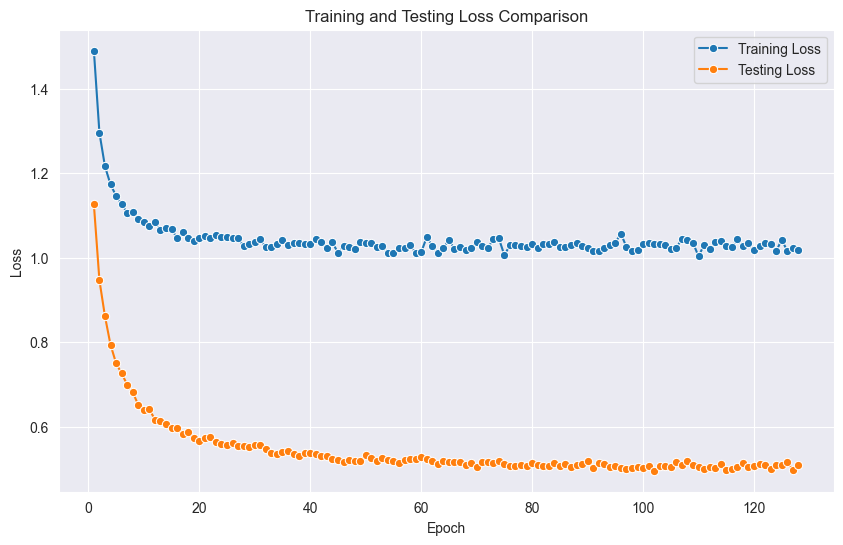

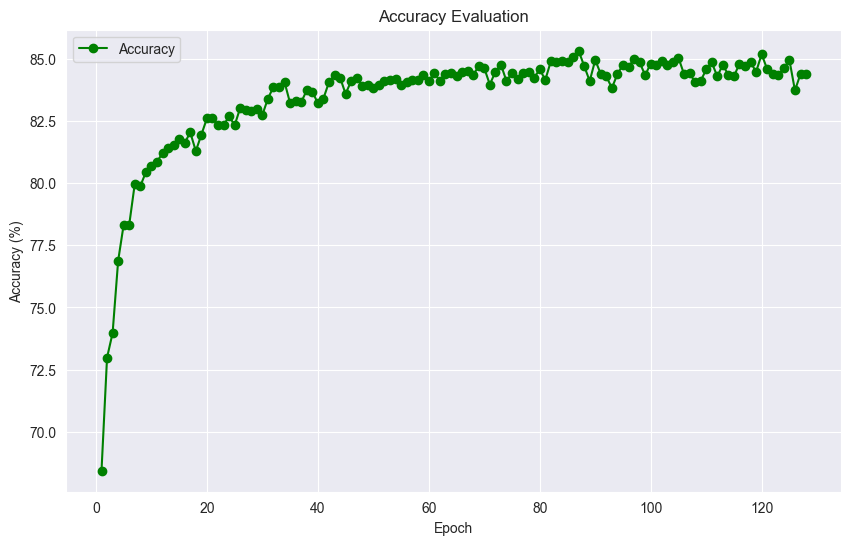

Historical data saved successfully!


In [12]:
import torch.optim as optim

hardware = torch.device('cuda' if   torch.cuda.is_available() else 'cpu')
classes = 6
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 128
criterion = nn.CrossEntropyLoss()

model = PestClassifierMobileNetV2(num_classes=classes).to(hardware)
# model.load_state_dict(torch.load('models/PestClassifierMobileNetV2.pth'))

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# # Phase 1

result_1, accuracies = train_and_test(model=model, optimizer=optimizer, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=num_epochs, device=hardware)

# # Phase 2
# model.unfreeze_last_block()
# print("\nPhase 2 Training\n")
#
# result_2, accuracies_2 = train_and_test(model=model, optimizer=optimizer, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=64, device=hardware)
#
# # Phase 3
# model.unfreeze_final_invert_residual()
# print("\nPhase 3 Training\n")
#
# result_3, accuracies_3 = train_and_test(model=model, optimizer=optimizer, criterion=criterion, train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=96, device=hardware)
#
# # Phase 4
# model.unfreeze_second_last_invert_residual()
# model.freeze_last_block()
# print("\nPhase 3 Training\n")
#
# result_4, accuracies_4 = train_and_test(model=model, optimizer=optimizer, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=128, device=hardware)
#
# print("Training Successful!")
# # Phase 5

# result_5, accuracies_5 = train_and_test(model=model, optimizer=optimizer, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=64, device=hardware)

plot_training_result(result_1)
plot_accuracy(result_1)
save_historical_data(result_1)

In [ ]:
import torch.optim as optim

hardware = torch.device('cuda' if   torch.cuda.is_available() else 'cpu')
classes = 6
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 64
criterion = nn.CrossEntropyLoss()

model = PestClassifierMobileNetV2(num_classes=classes).to(hardware)
model.load_state_dict(torch.load('models/SMobileNetV2_rice_pest_classificationV3.pth'))


optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=weight_decay)

model.unfreeze_final_invert_residual()

print("\nPhase 3 Training continuation\n")

result_3, accuracies_3 = train_and_test(model=model, optimizer=optimizer, criterion=criterion,train_dataloader=train_loader, test_dataloader=test_loader, num_epoch=64, device=hardware)

plot_training_result(result_3)
plot_accuracy(result_3)


In [ ]:
print( 1e-4)

In [10]:
from PIL import Image
import torch.nn.functional as F

def predict_single_image(model, image_path, classes, transform, device):

    model.to(device)

    model.eval()

    image = Image.open(image_path).convert('RGB')

    image_np = np.array(image)

    augmented = transform(image=image_np)

    image_tensor = augmented['image'].unsqueeze(0).to(device)

    with torch.no_grad():

        result = model(image_tensor)

        probability = F.softmax(result, dim=1)

        confidence, predicted = torch.max(probability, 1)

        predicted_class = classes[predicted.item()]
        confidence_score = confidence.item()

    return predicted_class, confidence_score


In [11]:
import torchvision.models as models

classes_names = train_set.classes
hardware = torch.device('cuda' if   torch.cuda.is_available() else 'cpu')
model_inference = PestClassifierMobileNetV2(num_classes=len(classes_names))
model_inference.load_state_dict(torch.load('models/SMobileNetV2_rice_pest_classificationV5.pth', map_location=hardware))
image_path = 'sample4.jpg'

pest, confidence_score = predict_single_image(model=model_inference, image_path=image_path, classes=classes_names, transform=validation_pipeline, device=hardware)

print(f"The predicted pest is: {pest}")
print(f"Confidence: {confidence_score * 100:.2f}%")

The predicted pest is: rice-leaf-folder
Confidence: 34.02%
